In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, RepeatVector, PReLU
from keras.losses import mse
from keras.constraints import non_neg

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 12

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [3]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [4]:
def train_nn(model, x, y, batch_size, loss, name, xval):

    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit(x, y,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=(xval,xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [6]:
runs = [304125,302263,304508]

with open('unscaled_data_WINDOW2.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
x_val = np.array(data[str(runs[1])]['samples'])
x_test = np.array(data[str(runs[2])]['samples'])

WINDOW = 2

1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224
1669 1669
1129 1129
1224 1224


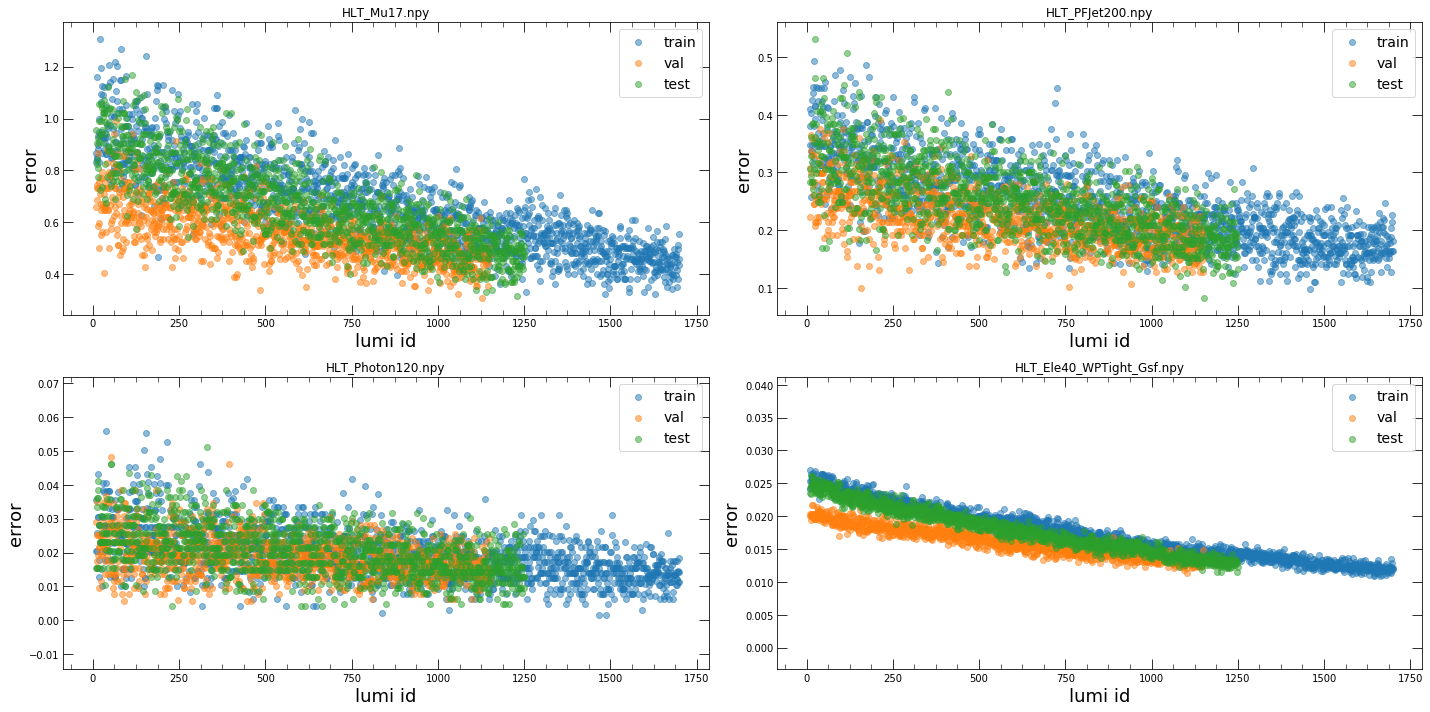

In [7]:
plots = [x_train,x_val,x_test]
titles = ["train","val","test"]

stuff = [[],[],[]]
lumi = [[],[],[]]
for h in range(3):
    labels = data['HLT'] 
    lumi[h] = data[str(runs[h])]['lumiid']
    stuff[h] = data[str(runs[h])]['rates']
    
plt.figure(figsize=[20,10])
              
for i in range(4):
    plt.subplot(2,2,i+1)
    for k in range(0,3):
        print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()
plt.show()

## Simple Autoencoder

In [8]:
model_name = "simplest_2"

In [9]:
# Define the architecture

_input = Input(shape=(4*WINDOW,), name="input")

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="encoded")(_input)

output = Dense(4*WINDOW,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(hidden)

model = Model(_input, output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 8)                 0         
_________________________________________________________________
encoded (Dense)              (None, 3)                 27        
_________________________________________________________________
reconstructed (Dense)        (None, 8)                 32        
Total params: 59
Trainable params: 59
Non-trainable params: 0
_________________________________________________________________


Train on 1668 samples, validate on 1128 samples
Epoch 1/1000
 - 0s - loss: 31.1131 - val_loss: 21.9479
Epoch 2/1000
 - 0s - loss: 30.3412 - val_loss: 21.4015
Epoch 3/1000
 - 0s - loss: 29.5887 - val_loss: 20.8741
Epoch 4/1000
 - 0s - loss: 28.8602 - val_loss: 20.3498
Epoch 5/1000
 - 0s - loss: 28.1321 - val_loss: 19.8371
Epoch 6/1000
 - 0s - loss: 27.4256 - val_loss: 19.3355
Epoch 7/1000
 - 0s - loss: 26.7277 - val_loss: 18.8444
Epoch 8/1000
 - 0s - loss: 26.0505 - val_loss: 18.3657
Epoch 9/1000
 - 0s - loss: 25.3852 - val_loss: 17.8986
Epoch 10/1000
 - 0s - loss: 24.7412 - val_loss: 17.4403
Epoch 11/1000
 - 0s - loss: 24.1114 - val_loss: 16.9934
Epoch 12/1000
 - 0s - loss: 23.4897 - val_loss: 16.5606
Epoch 13/1000
 - 0s - loss: 22.8940 - val_loss: 16.1363
Epoch 14/1000
 - 0s - loss: 22.3085 - val_loss: 15.7258
Epoch 15/1000
 - 0s - loss: 21.7383 - val_loss: 15.3241
Epoch 16/1000
 - 0s - loss: 21.1854 - val_loss: 14.9355
Epoch 17/1000
 - 0s - loss: 20.6475 - val_loss: 14.5554
Epoch 18/

Epoch 150/1000
 - 0s - loss: 1.4569 - val_loss: 1.0341
Epoch 151/1000
 - 0s - loss: 1.4350 - val_loss: 1.0186
Epoch 152/1000
 - 0s - loss: 1.4135 - val_loss: 1.0033
Epoch 153/1000
 - 0s - loss: 1.3924 - val_loss: 0.9884
Epoch 154/1000
 - 0s - loss: 1.3717 - val_loss: 0.9737
Epoch 155/1000
 - 0s - loss: 1.3514 - val_loss: 0.9593
Epoch 156/1000
 - 0s - loss: 1.3315 - val_loss: 0.9452
Epoch 157/1000
 - 0s - loss: 1.3119 - val_loss: 0.9313
Epoch 158/1000
 - 0s - loss: 1.2926 - val_loss: 0.9177
Epoch 159/1000
 - 0s - loss: 1.2736 - val_loss: 0.9043
Epoch 160/1000
 - 0s - loss: 1.2552 - val_loss: 0.8911
Epoch 161/1000
 - 0s - loss: 1.2370 - val_loss: 0.8782
Epoch 162/1000
 - 0s - loss: 1.2190 - val_loss: 0.8655
Epoch 163/1000
 - 0s - loss: 1.2014 - val_loss: 0.8530
Epoch 164/1000
 - 0s - loss: 1.1843 - val_loss: 0.8407
Epoch 165/1000
 - 0s - loss: 1.1672 - val_loss: 0.8287
Epoch 166/1000
 - 0s - loss: 1.1505 - val_loss: 0.8168
Epoch 167/1000
 - 0s - loss: 1.1342 - val_loss: 0.8052
Epoch 168/

Epoch 299/1000
 - 0s - loss: 0.2384 - val_loss: 0.1687
Epoch 300/1000
 - 0s - loss: 0.2360 - val_loss: 0.1671
Epoch 301/1000
 - 0s - loss: 0.2337 - val_loss: 0.1654
Epoch 302/1000
 - 0s - loss: 0.2315 - val_loss: 0.1638
Epoch 303/1000
 - 0s - loss: 0.2292 - val_loss: 0.1622
Epoch 304/1000
 - 0s - loss: 0.2270 - val_loss: 0.1607
Epoch 305/1000
 - 0s - loss: 0.2248 - val_loss: 0.1591
Epoch 306/1000
 - 0s - loss: 0.2227 - val_loss: 0.1576
Epoch 307/1000
 - 0s - loss: 0.2206 - val_loss: 0.1560
Epoch 308/1000
 - 0s - loss: 0.2184 - val_loss: 0.1545
Epoch 309/1000
 - 0s - loss: 0.2164 - val_loss: 0.1531
Epoch 310/1000
 - 0s - loss: 0.2143 - val_loss: 0.1516
Epoch 311/1000
 - 0s - loss: 0.2123 - val_loss: 0.1501
Epoch 312/1000
 - 0s - loss: 0.2103 - val_loss: 0.1487
Epoch 313/1000
 - 0s - loss: 0.2083 - val_loss: 0.1473
Epoch 314/1000
 - 0s - loss: 0.2063 - val_loss: 0.1459
Epoch 315/1000
 - 0s - loss: 0.2044 - val_loss: 0.1445
Epoch 316/1000
 - 0s - loss: 0.2025 - val_loss: 0.1432
Epoch 317/

Epoch 448/1000
 - 0s - loss: 0.0700 - val_loss: 0.0489
Epoch 449/1000
 - 0s - loss: 0.0696 - val_loss: 0.0486
Epoch 450/1000
 - 0s - loss: 0.0691 - val_loss: 0.0482
Epoch 451/1000
 - 0s - loss: 0.0686 - val_loss: 0.0479
Epoch 452/1000
 - 0s - loss: 0.0681 - val_loss: 0.0476
Epoch 453/1000
 - 0s - loss: 0.0677 - val_loss: 0.0472
Epoch 454/1000
 - 0s - loss: 0.0672 - val_loss: 0.0469
Epoch 455/1000
 - 0s - loss: 0.0668 - val_loss: 0.0466
Epoch 456/1000
 - 0s - loss: 0.0663 - val_loss: 0.0463
Epoch 457/1000
 - 0s - loss: 0.0659 - val_loss: 0.0459
Epoch 458/1000
 - 0s - loss: 0.0654 - val_loss: 0.0456
Epoch 459/1000
 - 0s - loss: 0.0650 - val_loss: 0.0453
Epoch 460/1000
 - 0s - loss: 0.0645 - val_loss: 0.0450
Epoch 461/1000
 - 0s - loss: 0.0641 - val_loss: 0.0447
Epoch 462/1000
 - 0s - loss: 0.0637 - val_loss: 0.0444
Epoch 463/1000
 - 0s - loss: 0.0632 - val_loss: 0.0441
Epoch 464/1000
 - 0s - loss: 0.0628 - val_loss: 0.0438
Epoch 465/1000
 - 0s - loss: 0.0624 - val_loss: 0.0435
Epoch 466/

Epoch 597/1000
 - 0s - loss: 0.0279 - val_loss: 0.0191
Epoch 598/1000
 - 0s - loss: 0.0277 - val_loss: 0.0190
Epoch 599/1000
 - 0s - loss: 0.0276 - val_loss: 0.0188
Epoch 600/1000
 - 0s - loss: 0.0274 - val_loss: 0.0187
Epoch 601/1000
 - 0s - loss: 0.0273 - val_loss: 0.0186
Epoch 602/1000
 - 0s - loss: 0.0271 - val_loss: 0.0185
Epoch 603/1000
 - 0s - loss: 0.0269 - val_loss: 0.0184
Epoch 604/1000
 - 0s - loss: 0.0268 - val_loss: 0.0183
Epoch 605/1000
 - 0s - loss: 0.0266 - val_loss: 0.0182
Epoch 606/1000
 - 0s - loss: 0.0265 - val_loss: 0.0181
Epoch 607/1000
 - 0s - loss: 0.0263 - val_loss: 0.0180
Epoch 608/1000
 - 0s - loss: 0.0262 - val_loss: 0.0179
Epoch 609/1000
 - 0s - loss: 0.0260 - val_loss: 0.0178
Epoch 610/1000
 - 0s - loss: 0.0259 - val_loss: 0.0177
Epoch 611/1000
 - 0s - loss: 0.0258 - val_loss: 0.0176
Epoch 612/1000
 - 0s - loss: 0.0256 - val_loss: 0.0175
Epoch 613/1000
 - 0s - loss: 0.0255 - val_loss: 0.0174
Epoch 614/1000
 - 0s - loss: 0.0253 - val_loss: 0.0173
Epoch 615/

Epoch 746/1000
 - 0s - loss: 0.0124 - val_loss: 0.0083
Epoch 747/1000
 - 0s - loss: 0.0124 - val_loss: 0.0083
Epoch 748/1000
 - 0s - loss: 0.0123 - val_loss: 0.0082
Epoch 749/1000
 - 0s - loss: 0.0122 - val_loss: 0.0082
Epoch 750/1000
 - 0s - loss: 0.0122 - val_loss: 0.0082
Epoch 751/1000
 - 0s - loss: 0.0121 - val_loss: 0.0081
Epoch 752/1000
 - 0s - loss: 0.0121 - val_loss: 0.0081
Epoch 753/1000
 - 0s - loss: 0.0120 - val_loss: 0.0080
Epoch 754/1000
 - 0s - loss: 0.0119 - val_loss: 0.0080
Epoch 755/1000
 - 0s - loss: 0.0119 - val_loss: 0.0079
Epoch 756/1000
 - 0s - loss: 0.0118 - val_loss: 0.0079
Epoch 757/1000
 - 0s - loss: 0.0118 - val_loss: 0.0079
Epoch 758/1000
 - 0s - loss: 0.0117 - val_loss: 0.0078
Epoch 759/1000
 - 0s - loss: 0.0116 - val_loss: 0.0078
Epoch 760/1000
 - 0s - loss: 0.0116 - val_loss: 0.0077
Epoch 761/1000
 - 0s - loss: 0.0115 - val_loss: 0.0077
Epoch 762/1000
 - 0s - loss: 0.0115 - val_loss: 0.0077
Epoch 763/1000
 - 0s - loss: 0.0114 - val_loss: 0.0076
Epoch 764/

Epoch 895/1000
 - 0s - loss: 0.0061 - val_loss: 0.0040
Epoch 896/1000
 - 0s - loss: 0.0060 - val_loss: 0.0040
Epoch 897/1000
 - 0s - loss: 0.0060 - val_loss: 0.0040
Epoch 898/1000
 - 0s - loss: 0.0060 - val_loss: 0.0040
Epoch 899/1000
 - 0s - loss: 0.0060 - val_loss: 0.0040
Epoch 900/1000
 - 0s - loss: 0.0059 - val_loss: 0.0040
Epoch 901/1000
 - 0s - loss: 0.0059 - val_loss: 0.0039
Epoch 902/1000
 - 0s - loss: 0.0059 - val_loss: 0.0039
Epoch 903/1000
 - 0s - loss: 0.0059 - val_loss: 0.0039
Epoch 904/1000
 - 0s - loss: 0.0058 - val_loss: 0.0039
Epoch 905/1000
 - 0s - loss: 0.0058 - val_loss: 0.0039
Epoch 906/1000
 - 0s - loss: 0.0058 - val_loss: 0.0039
Epoch 907/1000
 - 0s - loss: 0.0058 - val_loss: 0.0038
Epoch 908/1000
 - 0s - loss: 0.0057 - val_loss: 0.0038
Epoch 909/1000
 - 0s - loss: 0.0057 - val_loss: 0.0038
Epoch 910/1000
 - 0s - loss: 0.0057 - val_loss: 0.0038
Epoch 911/1000
 - 0s - loss: 0.0057 - val_loss: 0.0038
Epoch 912/1000
 - 0s - loss: 0.0056 - val_loss: 0.0038
Epoch 913/

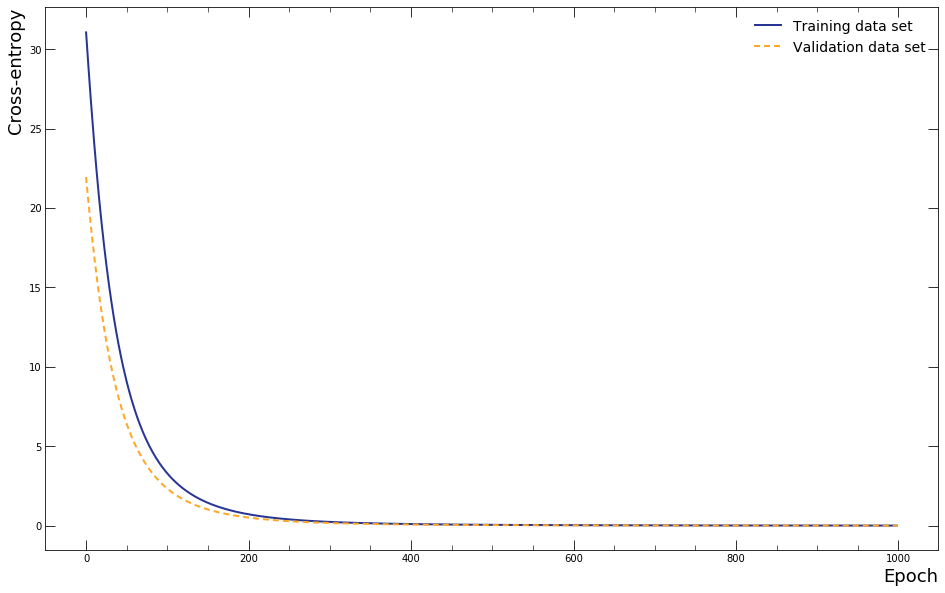

In [10]:
# Train neural networks
history = train_nn(model, x_train, x_train, 1024, "mse", model_name, x_val).history
plot_loss(history)

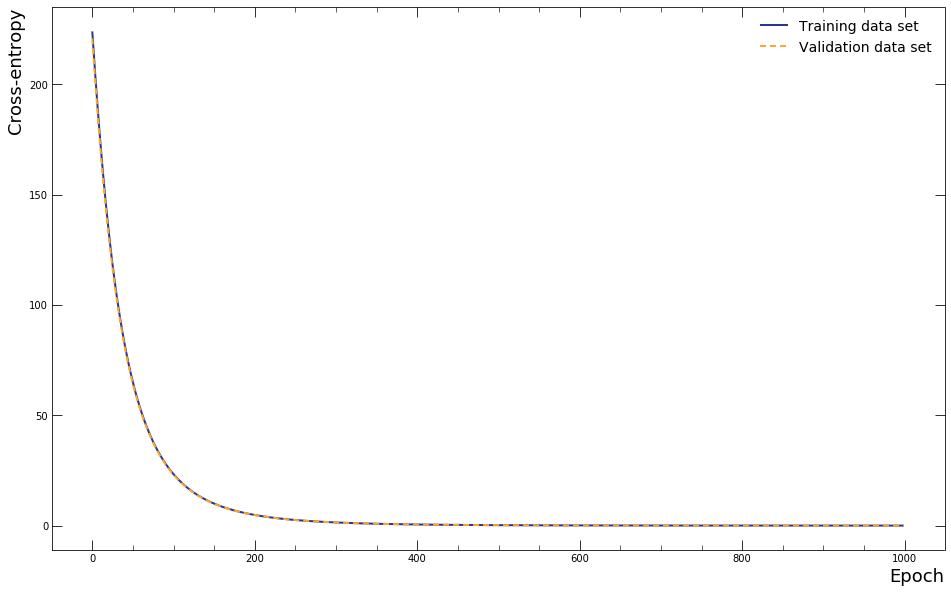

In [121]:
plot_loss(history)

## Training Data

In [11]:
# Generate predictions

model = load_model("%s.h5" % (model_name))
                
reconstructed = model.predict(np.array(x_train))

error = abs(x_train-reconstructed)/x_train

In [12]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_train[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_train[i][WINDOW*j])

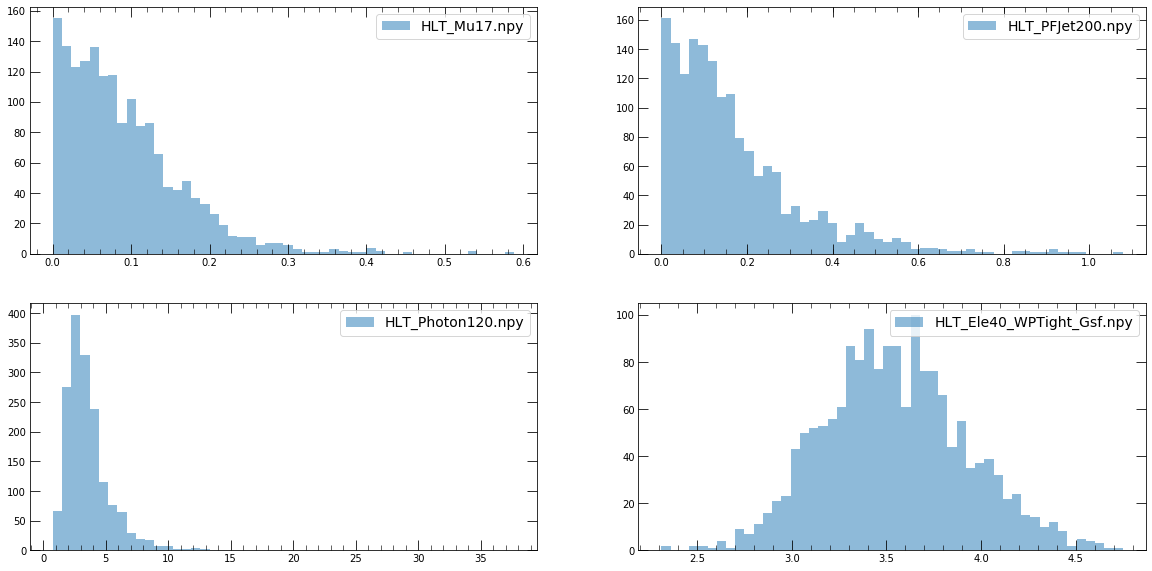

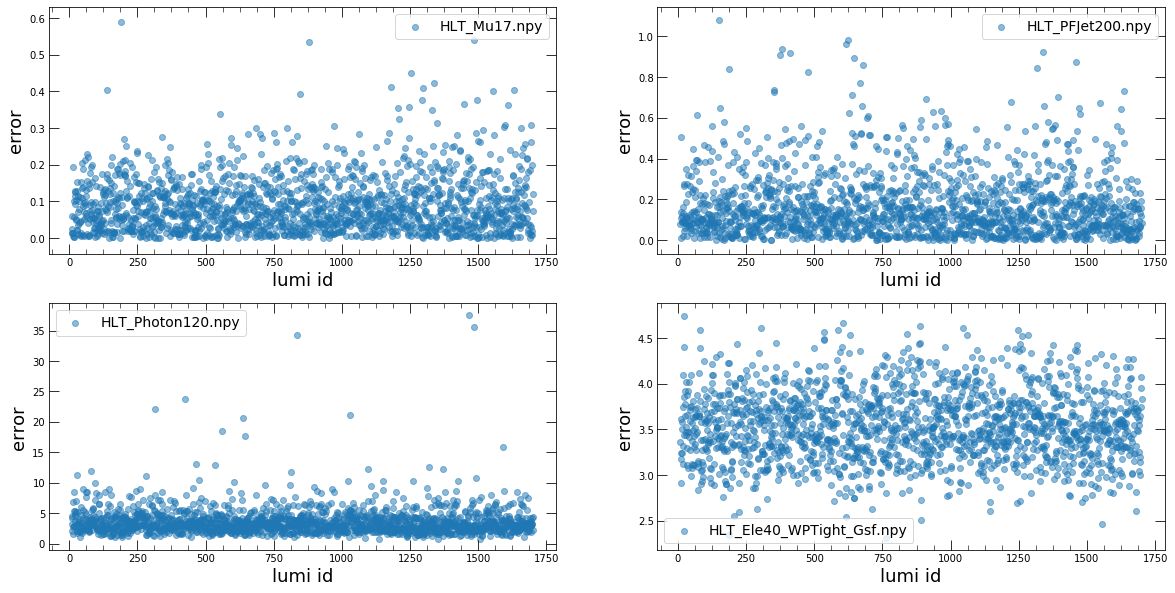

In [13]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[0])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

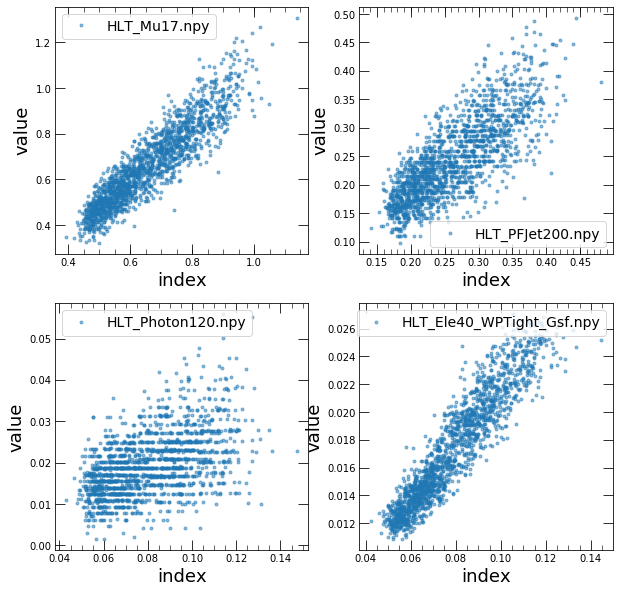

In [14]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

## Test Data

In [15]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

x_test_new = []
for l in x_test:
    if not 0 in l:
        x_test_new.append(l)
                
reconstructed = model.predict(np.array(x_test_new))

error = abs(x_test_new-reconstructed)/x_test_new

In [16]:
error_reformat = []
for i in range(4):
    error_reformat.append([])

for i in range(len(error)):
    for j in range(4):
        if i == len(error)-1:
            for val in error[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat[j].append(val)
        else:
            error_reformat[j].append(error[i][WINDOW*j])
            
inp = []
outp = []
for i in range(4):
    inp.append([])
    outp.append([])
    
for i in range(len(reconstructed)):
    for j in range(4):
        if i == len(reconstructed)-1:
            for val in reconstructed[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp[j].append(val)
            for val in x_test_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp[j].append(val)
        else:
            outp[j].append(reconstructed[i][WINDOW*j])
            inp[j].append(x_test_new[i][WINDOW*j])

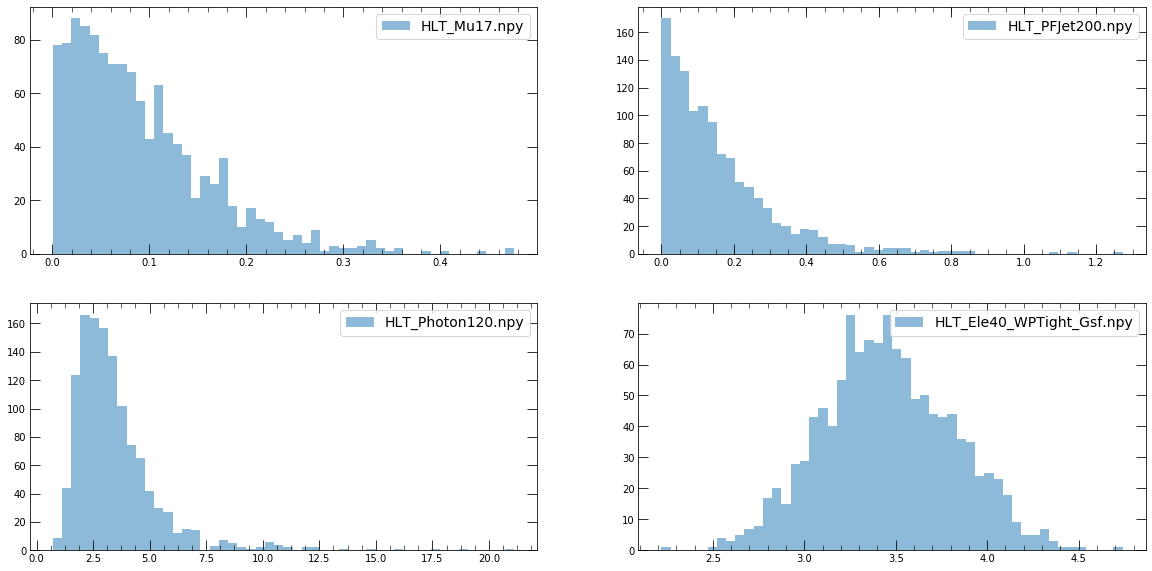

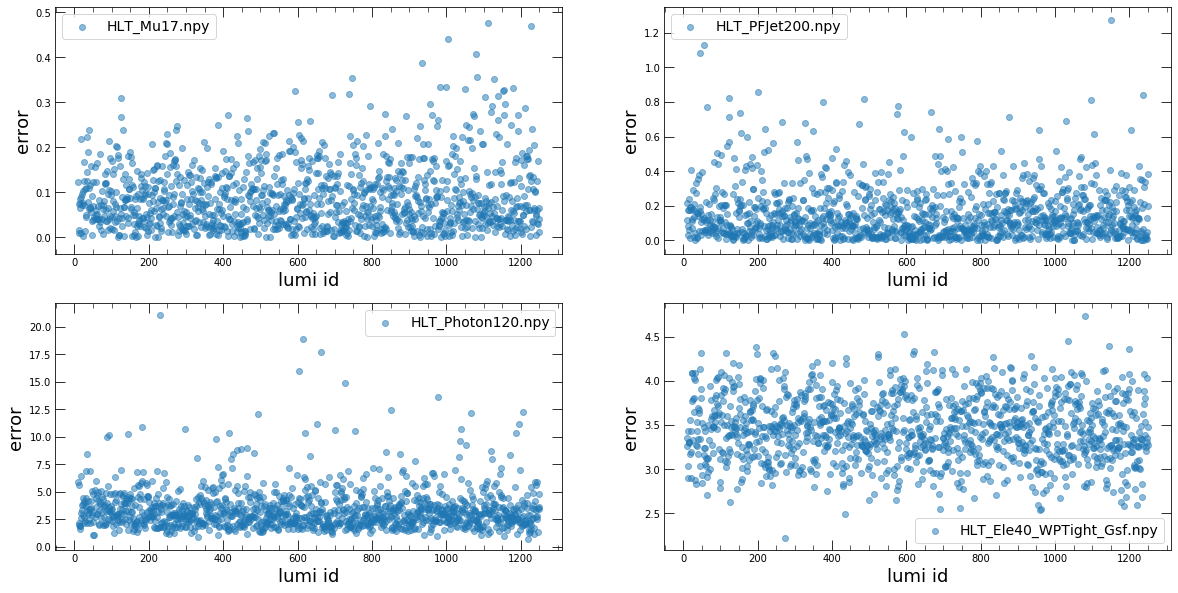

In [17]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()

lumi = data[str(runs[2])]['lumiid'] 
#lumi = np.linspace(0,len(error_reformat[0]),len(error_reformat[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.show()

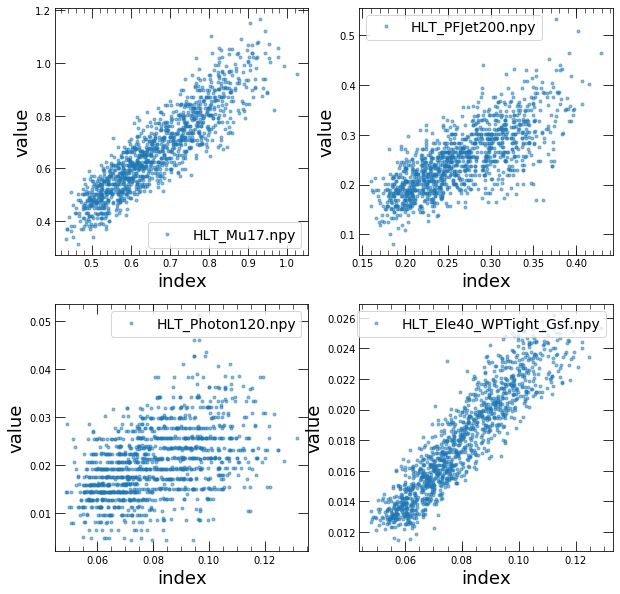

In [18]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi,outp[i],label='output',alpha=.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,1.8)
    #plt.ylim(0,1.8)
    plt.legend()    

plt.show()

In [19]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp[i]/max(outp[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [20]:
# for i in range(len(outp)):
#     for j in range(i+1,len(outp)):
#         print(sum(np.array(outp[i]/max(outp[i]))-np.array(outp[j]/max(outp[j]))))

## Fake Bad Data

In [21]:
bad = np.array(data[str(runs[2])]['bad_samples'])

In [22]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [23]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224


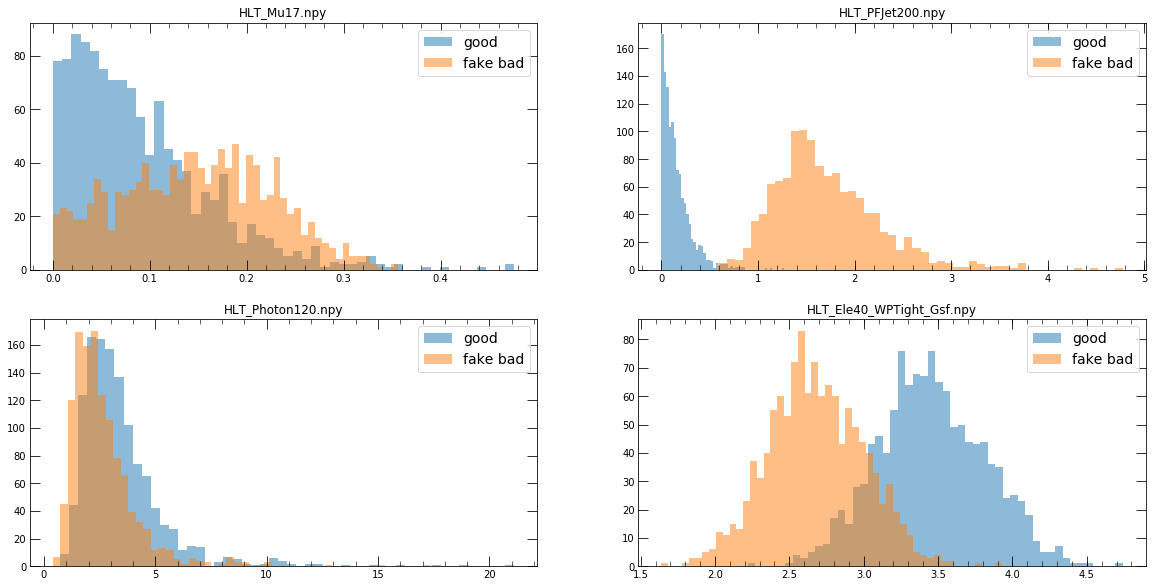

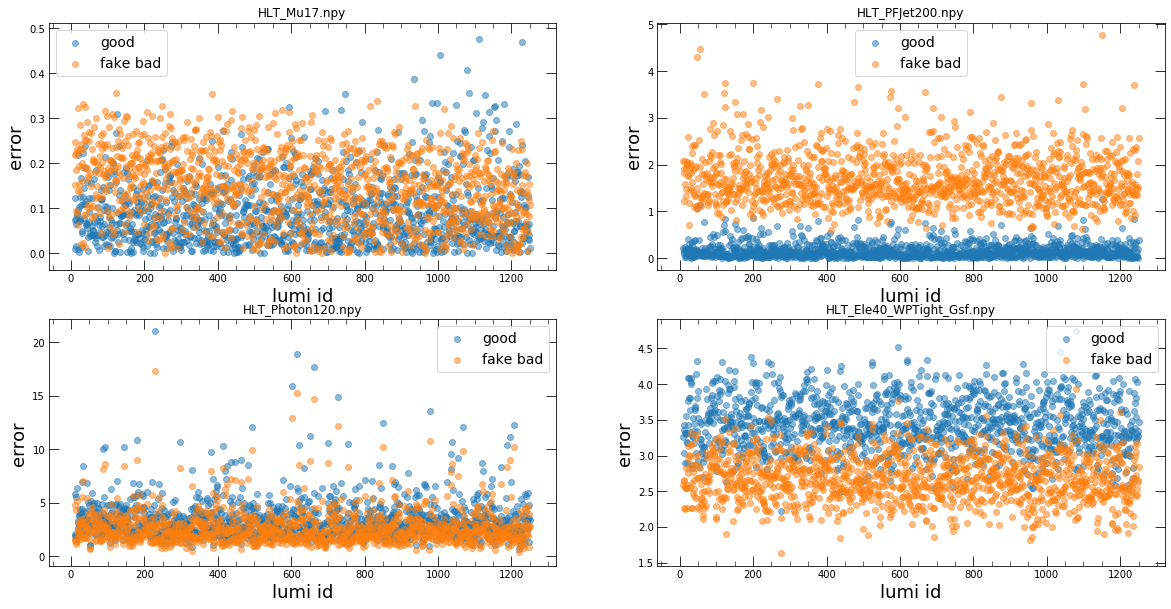

In [24]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

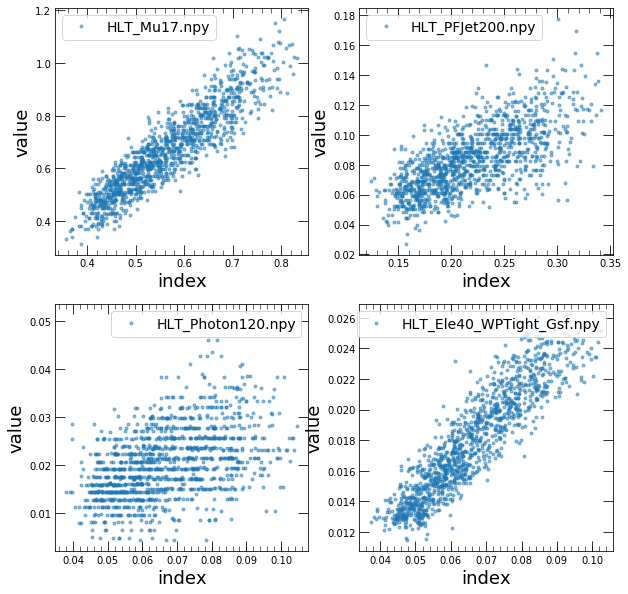

In [25]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,2)
    #plt.ylim(0,2)
    plt.legend()    

plt.show()

In [26]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='inp_badut',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='outp_badut',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [27]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Fake Bad Data - ALL

In [28]:
bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [29]:
bad_new = []
for l in bad:
    if not 0 in l:
        bad_new.append(l)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [30]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

1224 1224 1224


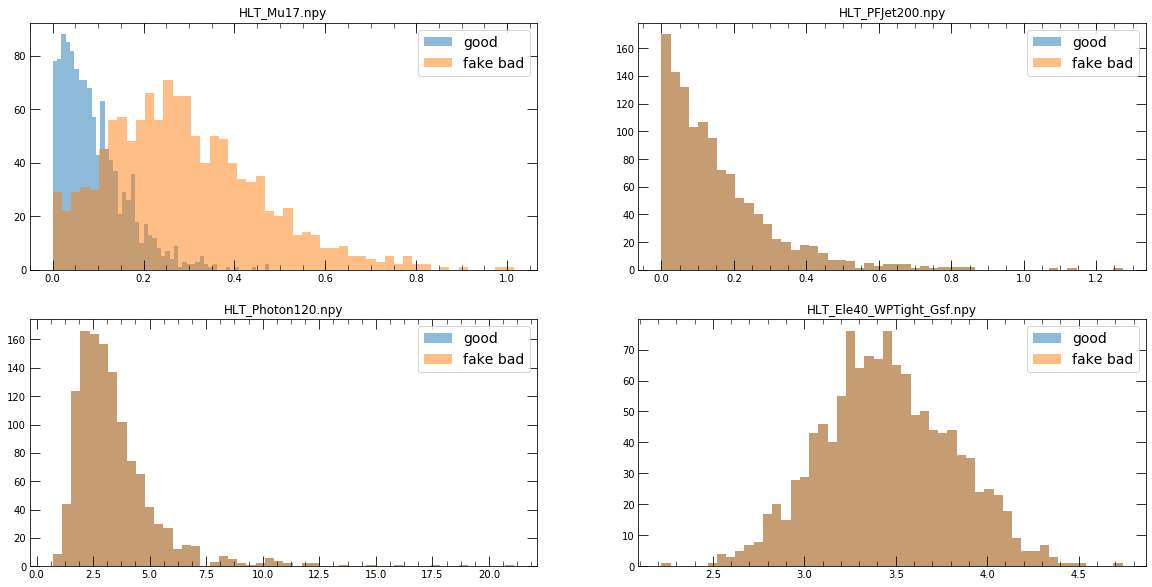

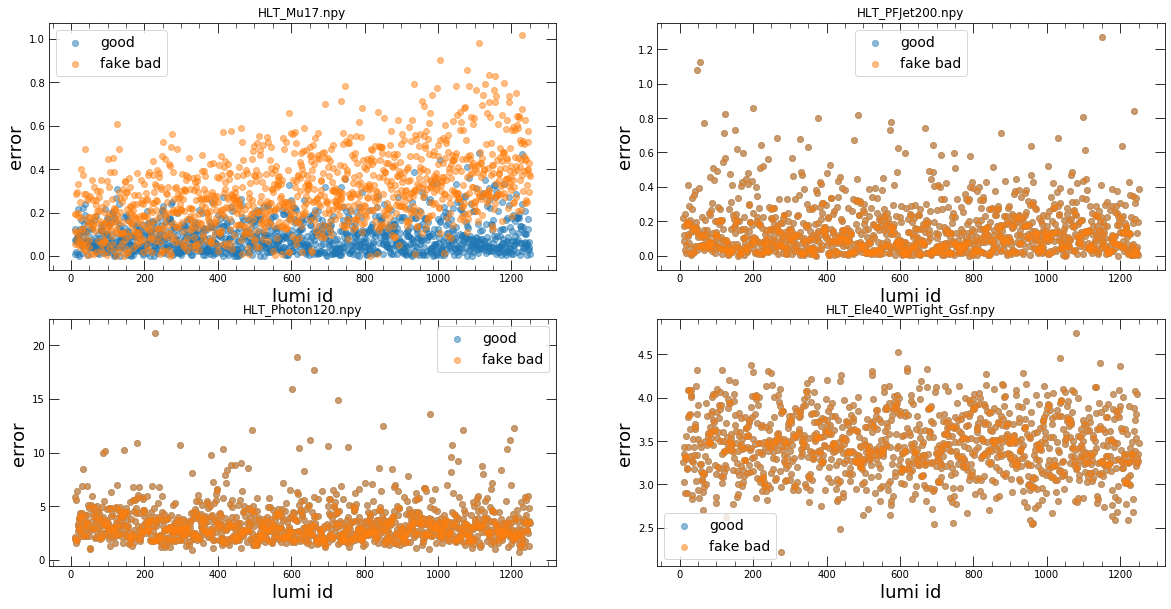

In [31]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='fake bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

lumi = data[str(runs[2])]['lumiid'] 
print(len(error_reformat_bad[0]),len(error_reformat[0]),len(lumi))
#lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi,error_reformat_bad[i],label='fake bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

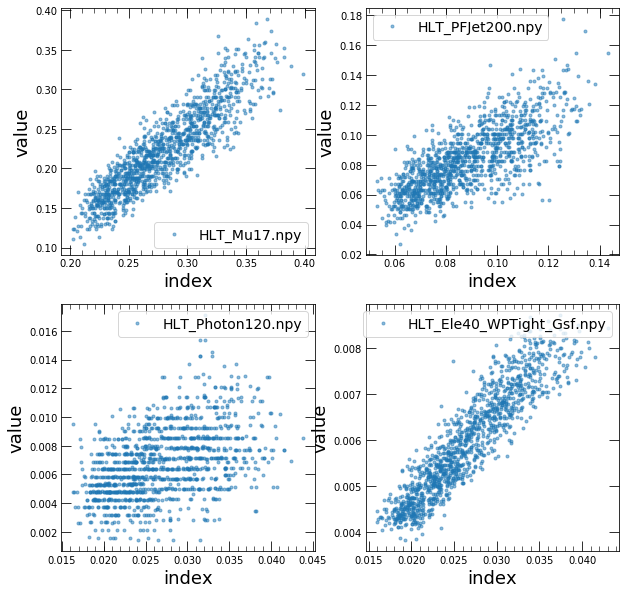

In [32]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

In [147]:
# plt.figure(figsize=[20,10])
# for i in range(0,4):
#     plt.subplot(2,2,i+1)
#     plt.scatter(lumi,inp_bad[i],label='input',alpha=.5)
#     plt.scatter(lumi,outp_bad[i]/max(outp_bad[i]),label='output',alpha=.5)
#     plt.xlabel('index')
#     plt.ylabel('value')
#     plt.legend()    

# plt.show()

In [148]:
# labels = data['HLT']

# #bins = np.linspace(0,1,50)
# bins = 50
# plt.figure(figsize=[20,10])
# for i in range(len(error_reformat_bad)):
#     plt.subplot(2,2,i+1)
#     plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
#     plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
#     plt.legend()

# # lumi = data[str(runs[0])]['lumiid'] 
# # print(len(error_reformat_bad[0]),len(lumi))
# # #lumi = np.linspace(0,len(error_reformat_bad[0]),len(error_reformat_bad[0]))
# # plt.figure(figsize=[20,10])
# # for i in range(0,4):
# #     plt.subplot(2,2,i+1)
# #     plt.scatter(lumi,error_reformat_bad[i],label='bad',alpha=.5)
# #     plt.scatter(lumi,error_reformat[i],label='good',alpha=.5)
# #     plt.xlabel('lumi id')
# #     plt.ylabel('error')
# #     plt.legend()    

# plt.show()

## Real Bad Data

In [33]:
bad_runs = [301480]

with open('unscaled_bad_data_WINDOW2.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [34]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [35]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

154 154


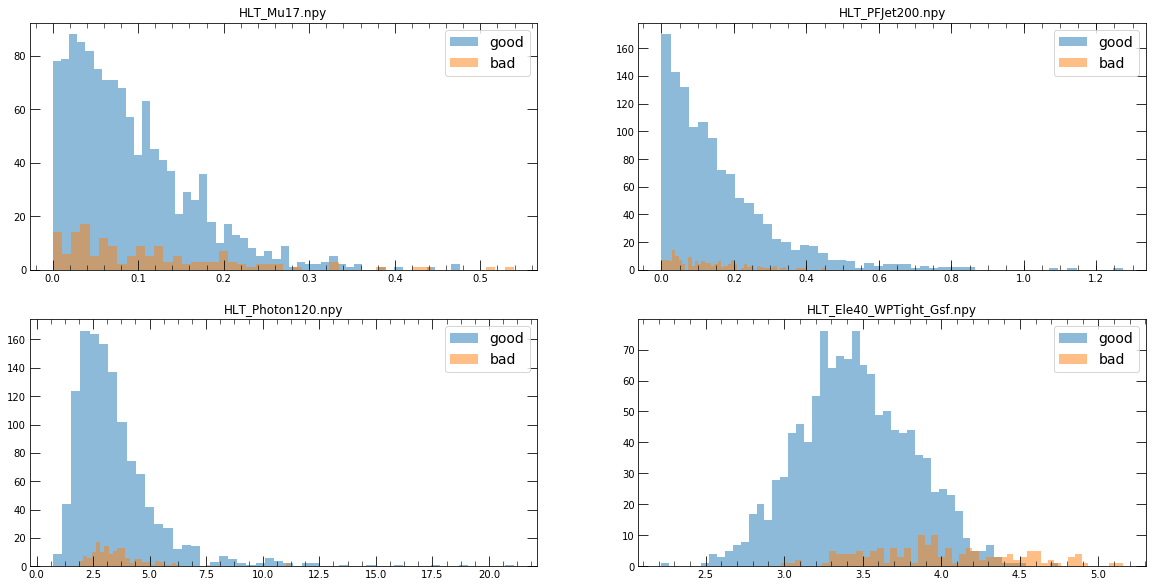

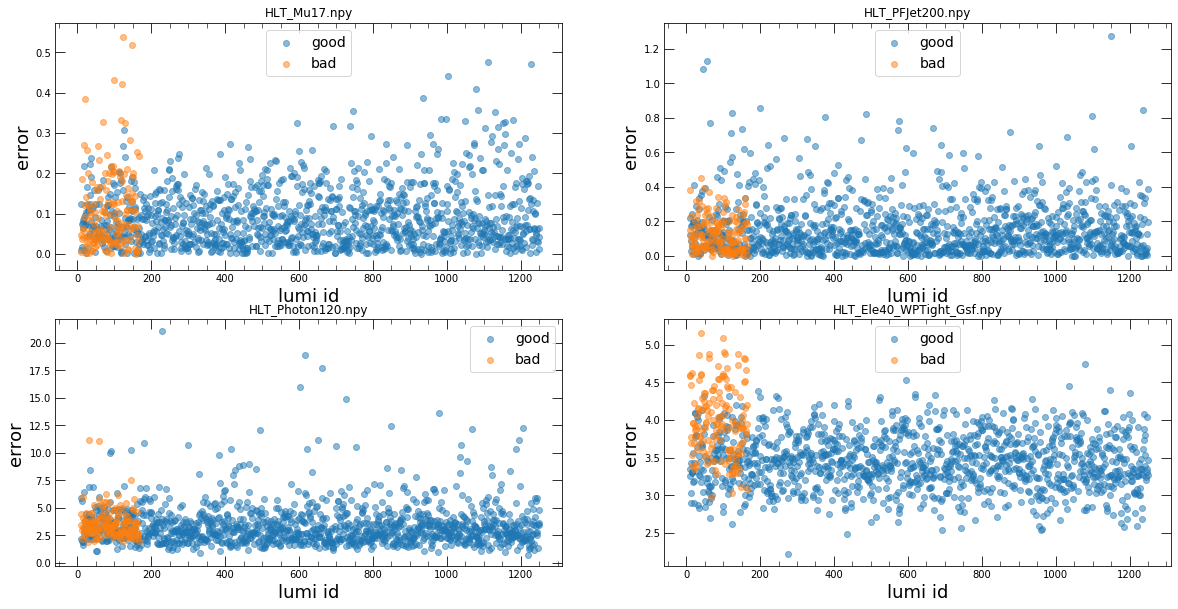

In [36]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

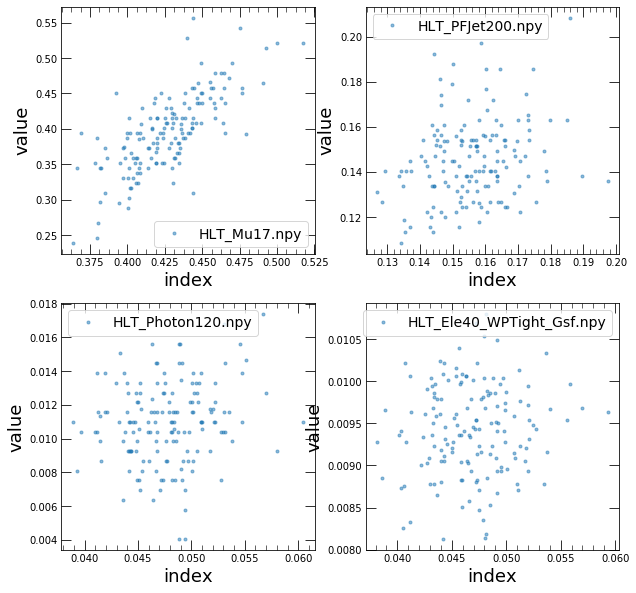

In [37]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()

## Real Bad Data

In [38]:
bad_runs = [305588]

with open('unscaled_bad_data_WINDOW2.pickle', 'rb') as handle:
    baddata = pickle.load(handle)

x_test = np.array(baddata[str(bad_runs[0])]['samples'])

In [39]:
bad_new = []
lumi_new = []

lumiBad = baddata[str(bad_runs[0])]['lumiid']

for l in range(len(x_test)):
    if not 0 in x_test[l]:
        bad_new.append(x_test[l])
        for i in range(WINDOW):
            lumi_new.append(lumiBad[l+i])
            
lumiBad = []
for n in lumi_new:
    if n not in lumiBad:
        lumiBad.append(n)
                
reconstructed_bad = model.predict(np.array(bad_new))

error_bad = abs(bad_new-reconstructed_bad)/bad_new

In [40]:
error_reformat_bad = []
for i in range(4):
    error_reformat_bad.append([])

for i in range(len(error_bad)):
    for j in range(4):
        if i == len(error_bad)-1:
            for val in error_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                error_reformat_bad[j].append(val)
        else:
            error_reformat_bad[j].append(error_bad[i][WINDOW*j])
            
inp_bad = []
outp_bad = []
for i in range(4):
    inp_bad.append([])
    outp_bad.append([])
    
for i in range(len(reconstructed_bad)):
    for j in range(4):
        if i == len(reconstructed_bad)-1:
            for val in reconstructed_bad[i][WINDOW*j:WINDOW+WINDOW*j]:
                outp_bad[j].append(val)
            for val in bad_new[i][WINDOW*j:WINDOW+WINDOW*j]:
                inp_bad[j].append(val)
        else:
            outp_bad[j].append(reconstructed_bad[i][WINDOW*j])
            inp_bad[j].append(bad_new[i][WINDOW*j])
            
        

99 99


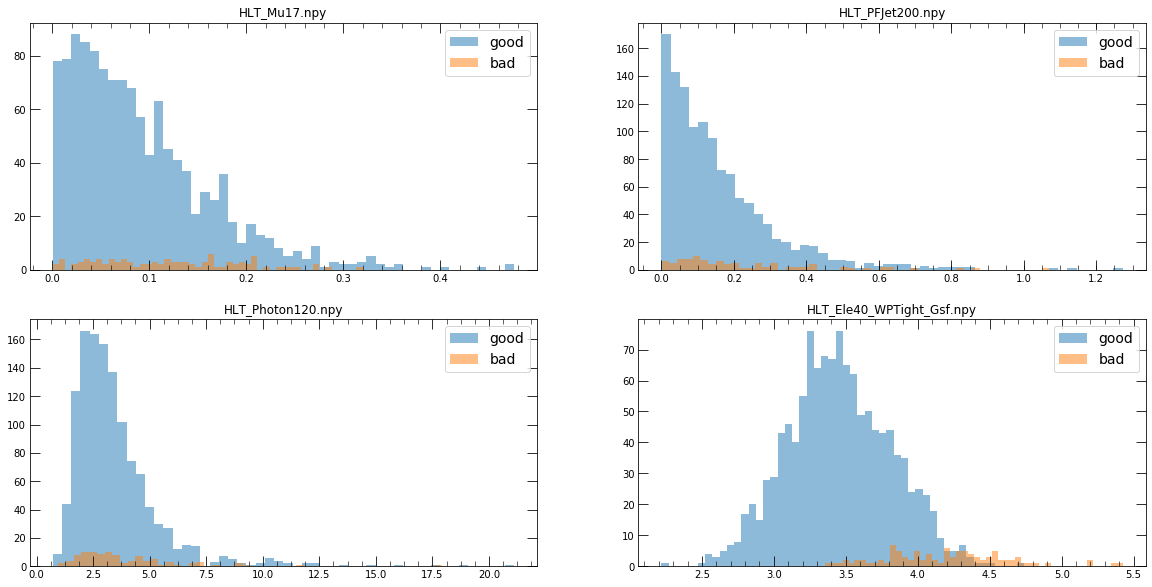

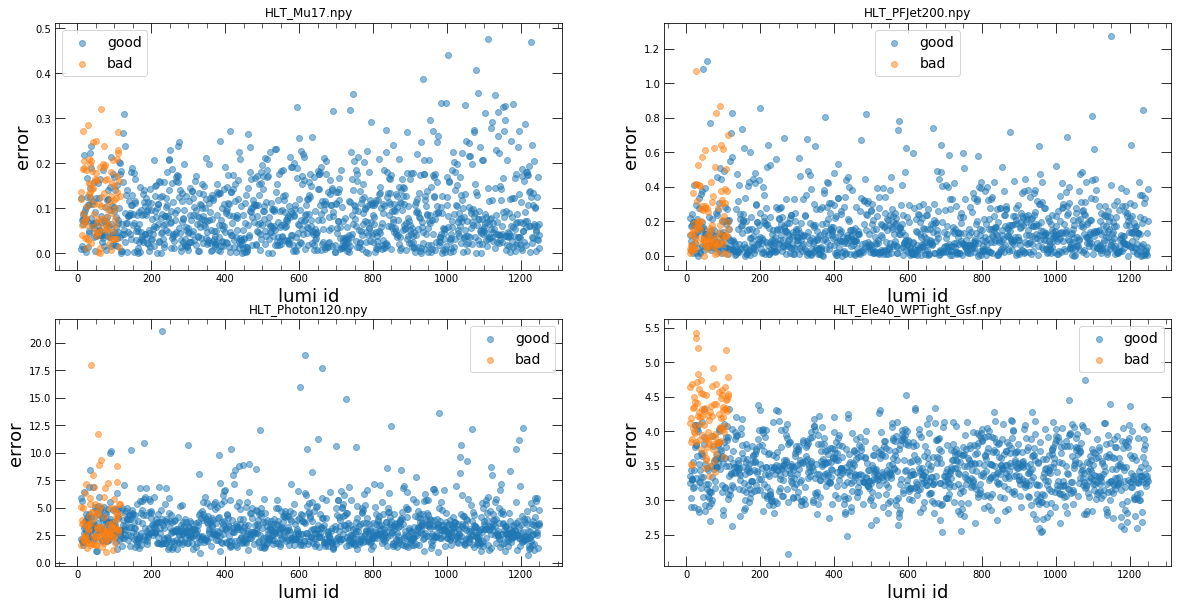

In [41]:
labels = data['HLT']

#bins = np.linspace(0,1,50)
bins = 50
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_bad)):
    plt.subplot(2,2,i+1)
    plt.hist(error_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_bad[i],bins=bins,label='bad',alpha=.5)
    plt.legend()
    plt.title(labels[i])

print(len(error_reformat_bad[0]),len(lumiBad))
plt.figure(figsize=[20,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.scatter(lumi,error_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumiBad,error_reformat_bad[i],label='bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.show()

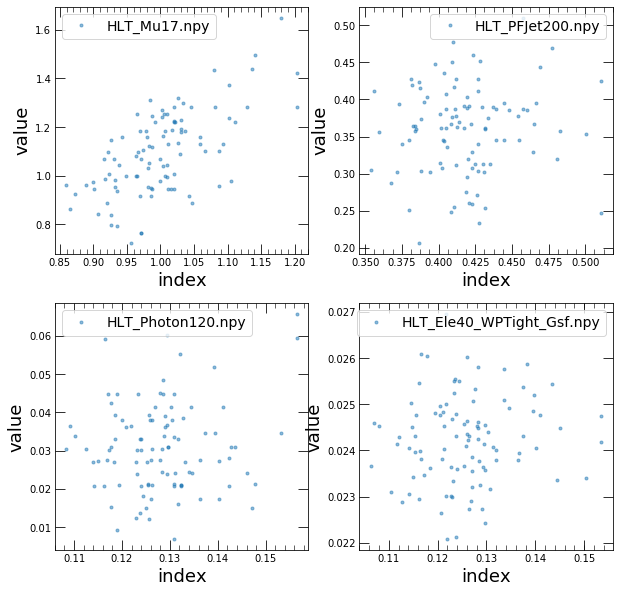

In [42]:
plt.figure(figsize=[10,10])
for i in range(0,4):
    plt.subplot(2,2,i+1)
    plt.plot(outp_bad[i],inp_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('index')
    plt.ylabel('value')
    #plt.xlim(0,.6)
    #plt.ylim(0,.6)
    plt.legend()    

plt.show()